Detecção de Fraude

Importando bibliotecas

In [48]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [2]:
df = pd.read_csv('fraud_dataset_example.csv')

In [3]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Reorganizando a sequencia de colunas

In [5]:
df = df[['isFraud',
       'isFlaggedFraud','step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']]

In [6]:
df.head()

isFraud  isFlaggedFraud  step      type    amount     nameOrig  \
0        0               0     1   PAYMENT   9839.64  C1231006815   
1        0               0     1   PAYMENT   1864.28  C1666544295   
2        1               0     1  TRANSFER    181.00  C1305486145   
3        1               0     1  CASH_OUT    181.00   C840083671   
4        0               0     1   PAYMENT  11668.14  C2048537720   

   oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  
0       170136.0       160296.36  M1979787155             0.0             0.0  
1        21249.0        19384.72  M2044282225             0.0             0.0  
2          181.0            0.00   C553264065             0.0             0.0  
3          181.0            0.00    C38997010         21182.0             0.0  
4        41554.0        29885.86  M1230701703             0.0             0.0

Renomeando as colunas

In [7]:
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

In [8]:
df = df.rename(columns= colunas)
df.head()

fraude  super_fraude  tempo      tipo     valor     cliente1  \
0       0             0      1   PAYMENT   9839.64  C1231006815   
1       0             0      1   PAYMENT   1864.28  C1666544295   
2       1             0      1  TRANSFER    181.00  C1305486145   
3       1             0      1  CASH_OUT    181.00   C840083671   
4       0             0      1   PAYMENT  11668.14  C2048537720   

   saldo_inicial_c1  novo_saldo_c1     cliente2  saldo_inicial_c2  \
0          170136.0      160296.36  M1979787155               0.0   
1           21249.0       19384.72  M2044282225               0.0   
2             181.0           0.00   C553264065               0.0   
3             181.0           0.00    C38997010           21182.0   
4           41554.0       29885.86  M1230701703               0.0   

   novo_saldo_c2  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

Conhecendo os dados estatísticos dos dados

In [9]:
df.describe().T

count          mean           std   min       25%  \
fraude            101613.0  1.141586e-03  3.376824e-02  0.00      0.00   
super_fraude      101613.0  0.000000e+00  0.000000e+00  0.00      0.00   
tempo             101613.0  8.523457e+00  1.820681e+00  1.00      8.00   
valor             101613.0  1.740901e+05  3.450199e+05  0.32  10016.59   
saldo_inicial_c1  101613.0  9.071753e+05  2.829575e+06  0.00      0.00   
novo_saldo_c1     101613.0  9.234992e+05  2.867319e+06  0.00      0.00   
saldo_inicial_c2  101613.0  8.810428e+05  2.399949e+06  0.00      0.00   
novo_saldo_c2     101613.0  1.183998e+06  2.797761e+06  0.00      0.00   

                       50%         75%          max  
fraude                0.00        0.00         1.00  
super_fraude          0.00        0.00         0.00  
tempo                 9.00       10.00        10.00  
valor             53385.41   212498.40  10000000.00  
saldo_inicial_c1  20190.47   194715.00  38939424.03  
novo_saldo_c1         0.00   219217.76  38946233.02  
saldo_inicial_c2  21058.00   591921.70  34008736.98  
novo_saldo_c2     51783.43  1063121.64  38946233.02

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   tipo              101613 non-null  object 
 4   valor             101613 non-null  float64
 5   cliente1          101613 non-null  object 
 6   saldo_inicial_c1  101613 non-null  float64
 7   novo_saldo_c1     101613 non-null  float64
 8   cliente2          101613 non-null  object 
 9   saldo_inicial_c2  101613 non-null  float64
 10  novo_saldo_c2     101613 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


In [11]:
df.shape

(101613, 11)

Verificando a variável target

In [12]:
df.groupby('fraude')['tempo'].count()

fraude
0    101497
1       116
Name: tempo, dtype: int64

In [13]:
df.isnull().values.any()

False

In [14]:
from ydata_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Aplicando Encoding

In [15]:
df = pd.get_dummies(data=df, columns= ['tipo'])
df.head()

fraude  super_fraude  tempo     valor     cliente1  saldo_inicial_c1  \
0       0             0      1   9839.64  C1231006815          170136.0   
1       0             0      1   1864.28  C1666544295           21249.0   
2       1             0      1    181.00  C1305486145             181.0   
3       1             0      1    181.00   C840083671             181.0   
4       0             0      1  11668.14  C2048537720           41554.0   

   novo_saldo_c1     cliente2  saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  \
0      160296.36  M1979787155               0.0            0.0         False   
1       19384.72  M2044282225               0.0            0.0         False   
2           0.00   C553264065               0.0            0.0         False   
3           0.00    C38997010           21182.0            0.0         False   
4       29885.86  M1230701703               0.0            0.0         False   

   tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0          False       False          True          False  
1          False       False          True          False  
2          False       False         False           True  
3           True       False         False          False  
4          False       False          True          False

In [16]:
df[['tipo_CASH_IN', 'tipo_CASH_OUT', 'tipo_DEBIT', 'tipo_PAYMENT', 'tipo_TRANSFER']] = df[['tipo_CASH_IN', 'tipo_CASH_OUT', 'tipo_DEBIT', 'tipo_PAYMENT', 'tipo_TRANSFER']].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   valor             101613 non-null  float64
 4   cliente1          101613 non-null  object 
 5   saldo_inicial_c1  101613 non-null  float64
 6   novo_saldo_c1     101613 non-null  float64
 7   cliente2          101613 non-null  object 
 8   saldo_inicial_c2  101613 non-null  float64
 9   novo_saldo_c2     101613 non-null  float64
 10  tipo_CASH_IN      101613 non-null  int32  
 11  tipo_CASH_OUT     101613 non-null  int32  
 12  tipo_DEBIT        101613 non-null  int32  
 13  tipo_PAYMENT      101613 non-null  int32  
 14  tipo_TRANSFER     101613 non-null  int32  
dtypes: float64(5), int32(5), int64(3), object(2)
memory usage: 9.7+ MB


In [17]:
df.head()

fraude  super_fraude  tempo     valor     cliente1  saldo_inicial_c1  \
0       0             0      1   9839.64  C1231006815          170136.0   
1       0             0      1   1864.28  C1666544295           21249.0   
2       1             0      1    181.00  C1305486145             181.0   
3       1             0      1    181.00   C840083671             181.0   
4       0             0      1  11668.14  C2048537720           41554.0   

   novo_saldo_c1     cliente2  saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  \
0      160296.36  M1979787155               0.0            0.0             0   
1       19384.72  M2044282225               0.0            0.0             0   
2           0.00   C553264065               0.0            0.0             0   
3           0.00    C38997010           21182.0            0.0             0   
4       29885.86  M1230701703               0.0            0.0             0   

   tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0              0           0             1              0  
1              0           0             1              0  
2              0           0             0              1  
3              1           0             0              0  
4              0           0             1              0

Removendo variáveis

In [18]:
df = df.drop(['cliente1', 'cliente2', 'super_fraude'], axis = 1)
df.head()

fraude  tempo     valor  saldo_inicial_c1  novo_saldo_c1  saldo_inicial_c2  \
0       0      1   9839.64          170136.0      160296.36               0.0   
1       0      1   1864.28           21249.0       19384.72               0.0   
2       1      1    181.00             181.0           0.00               0.0   
3       1      1    181.00             181.0           0.00           21182.0   
4       0      1  11668.14           41554.0       29885.86               0.0   

   novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  \
0            0.0             0              0           0             1   
1            0.0             0              0           0             1   
2            0.0             0              0           0             0   
3            0.0             0              1           0             0   
4            0.0             0              0           0             1   

   tipo_TRANSFER  
0              0  
1              0  
2              1  
3              0  
4              0

Aplicando regressão Logística

In [19]:
x = df.drop('fraude',axis= 1)
y = df['fraude']


In [20]:
SEED = 42
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=SEED) # SEED deixa os dados replicaveis

In [21]:
y_test

690      0
46856    0
87115    0
57005    0
40495    0
        ..
89731    0
94467    0
38014    0
46897    0
37074    0
Name: fraude, Length: 25404, dtype: int64

In [22]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)


Imprimindo as metricas de validação

In [23]:
print("Acuracia", metrics.accuracy_score(y_test,y_pred))
print("previsao", metrics.precision_score(y_test,y_pred))
print("Recall", metrics.recall_score(y_test,y_pred))
print("F1", metrics.f1_score(y_test,y_pred))

Acuracia 0.9989765391276965
previsao 0.2
Recall 0.043478260869565216
F1 0.07142857142857142


Matrix de Confusão

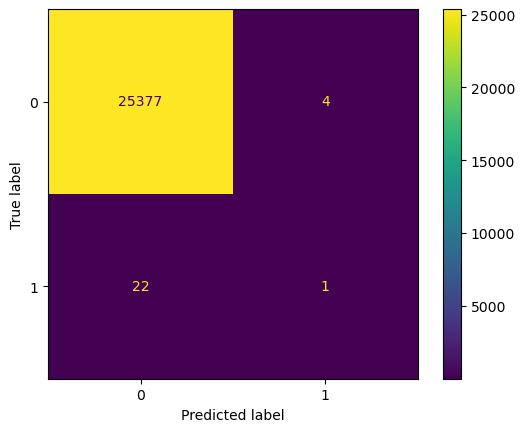

In [24]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Curva ROC

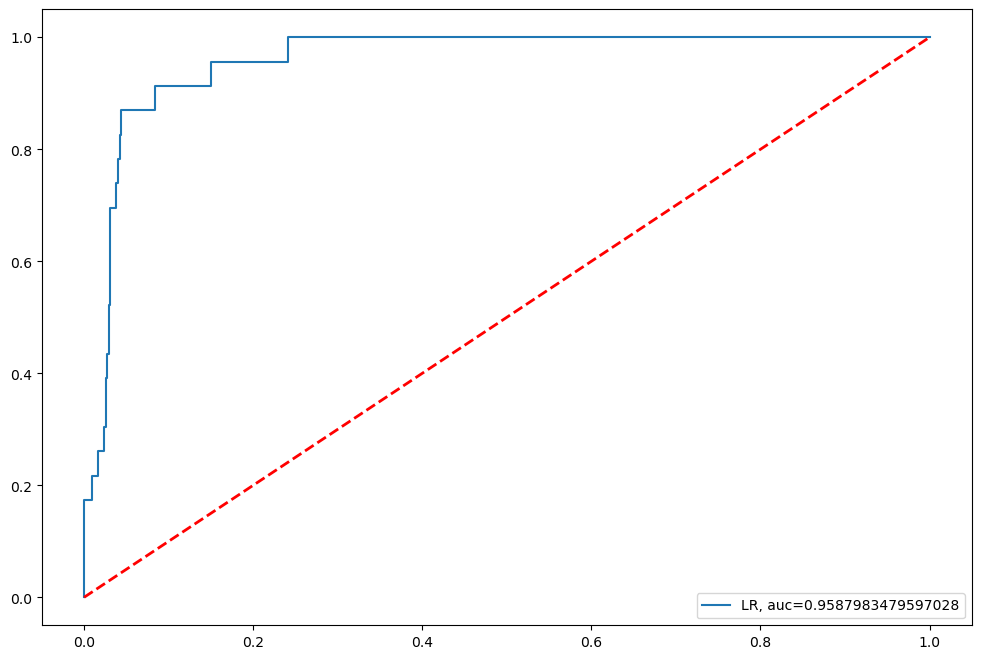

In [25]:
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)



Balanceamento de dados

In [26]:
smote = SMOTE(random_state=SEED)
x = df.drop('fraude', axis=1)
y = df['fraude']

In [27]:
x_resampled, y_resampled = smote.fit_resample(x,y )

In [28]:
df_balanced = pd.concat([y_resampled, x_resampled], axis=1)
df_balanced

fraude  tempo          valor  saldo_inicial_c1  novo_saldo_c1  \
0            0      1    9839.640000     170136.000000      160296.36   
1            0      1    1864.280000      21249.000000       19384.72   
2            1      1     181.000000        181.000000           0.00   
3            1      1     181.000000        181.000000           0.00   
4            0      1   11668.140000      41554.000000       29885.86   
...        ...    ...            ...               ...            ...   
202989       1      5   17608.962863      17608.962863           0.00   
202990       1      7   12116.291013      12116.291013           0.00   
202991       1      1  231612.880715     231612.880715           0.00   
202992       1      9  547325.144758     547325.144758           0.00   
202993       1      4  159298.594420     159298.594420           0.00   

        saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  \
0               0.000000       0.000000             0              0   
1               0.000000       0.000000             0              0   
2               0.000000       0.000000             0              0   
3           21182.000000       0.000000             0              1   
4               0.000000       0.000000             0              0   
...                  ...            ...           ...            ...   
202989          0.000000       0.000000             0              0   
202990          0.000000       0.000000             0              0   
202991       1945.589357    9370.603471             0              0   
202992          0.000000       0.000000             0              0   
202993          0.000000       0.000000             0              0   

        tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0                0             1              0  
1                0             1              0  
2                0             0              1  
3                0             0              0  
4                0             1              0  
...            ...           ...            ...  
202989           0             0              1  
202990           0             0              1  
202991           0             0              0  
202992           0             0              1  
202993           0             0              1  

[202994 rows x 12 columns]

In [29]:
df_balanced.groupby('fraude').tempo.count()

fraude
0    101497
1    101497
Name: tempo, dtype: int64

Testando o modelo com dados sinteticos

In [30]:
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = SEED)
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(x_train, y_train)
y_pred =lr.predict(x_test)
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))


Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


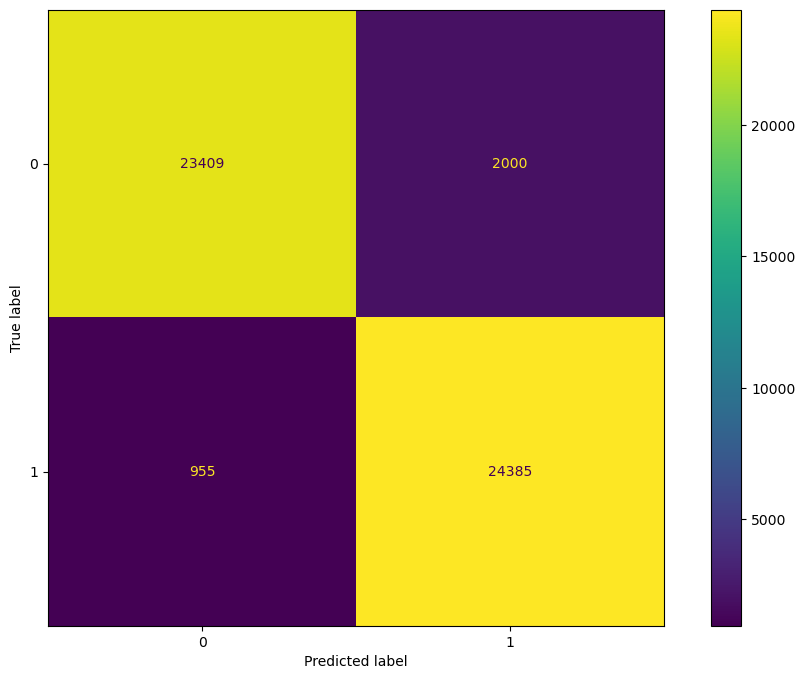

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

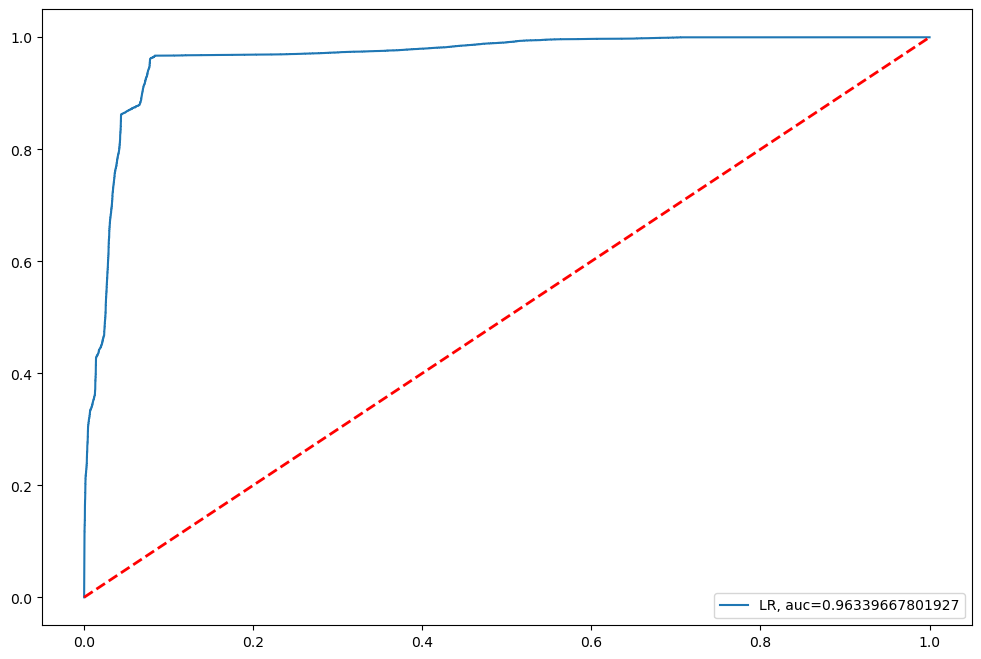

In [33]:
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


Formulando Hipóteses

In [34]:
ProfileReport(df_balanced)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*
- tipo_PAYMENT -> é o que a pessoa utiliza como padrão e a fraude ocorre por meio de tipo_TRANSFER

- o cliente pode fazer os seus pagamentos durante um periodo do dia exemplo pela manha e a fraude ocorre na madrugada

- o cliente constuma pagar as contas nos primeiros 10 dias do mes e ocorre uma movimentação no dia 23
*

Decision tree

In [35]:
dt = DecisionTreeClassifier(max_depth= 5 , random_state= SEED)

In [36]:
model = dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


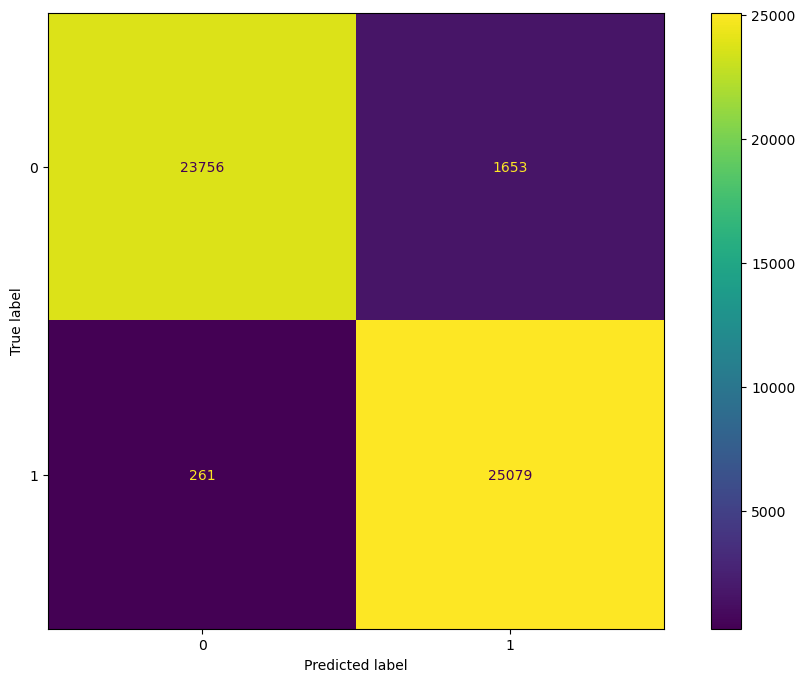

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


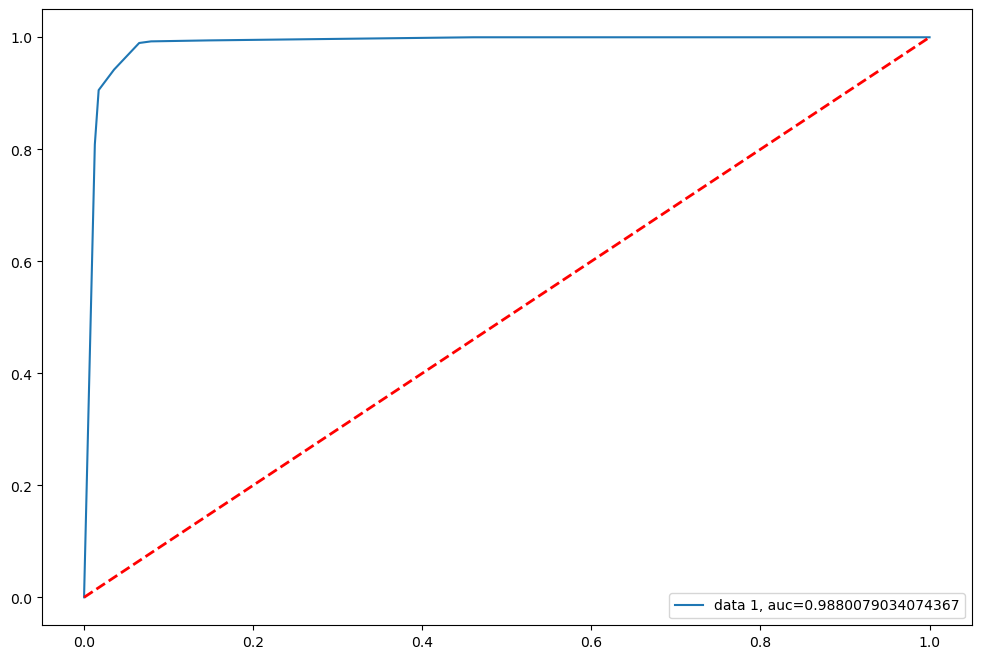

In [38]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


Random Forest

In [39]:
rf = RandomForestClassifier(max_depth= 5, random_state= SEED)

In [40]:
model = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)


In [41]:
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


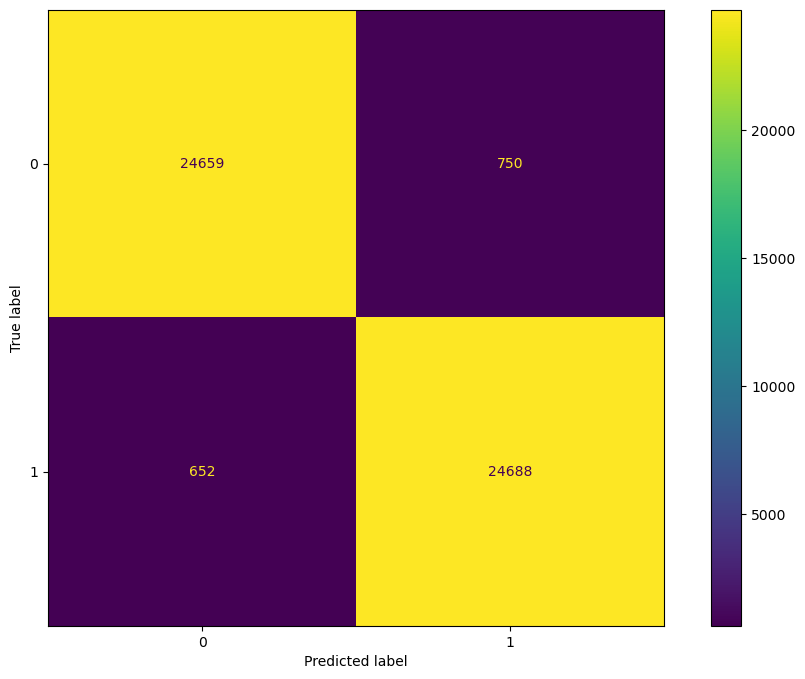

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


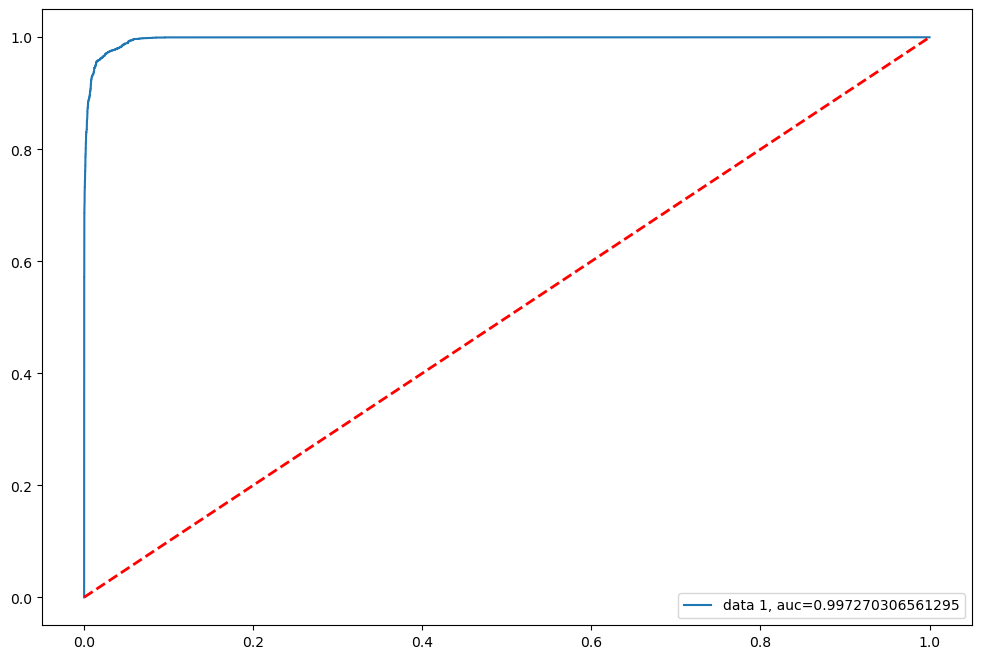

In [43]:
y_pred_proba =  rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


Análise de Métricas

In [44]:
classifiers = [
    LogisticRegression(max_iter=1000, random_state=SEED),
    DecisionTreeClassifier(max_depth = 5, random_state=SEED),
    RandomForestClassifier(max_depth= 5, random_state = SEED)]


LogisticRegression
****Resultados****
Accuracy: 0.9417722516699837
Precision: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975
DecisionTreeClassifier
****Resultados****
Accuracy: 0.9622849711324362
Precision: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943
RandomForestClassifier
****Resultados****
Accuracy: 0.9723738398786183
Precision: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


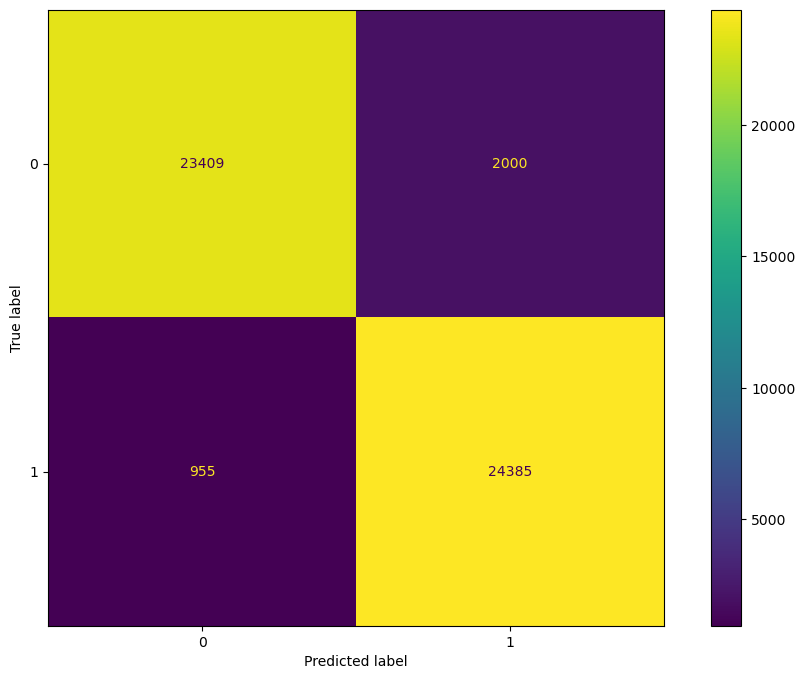

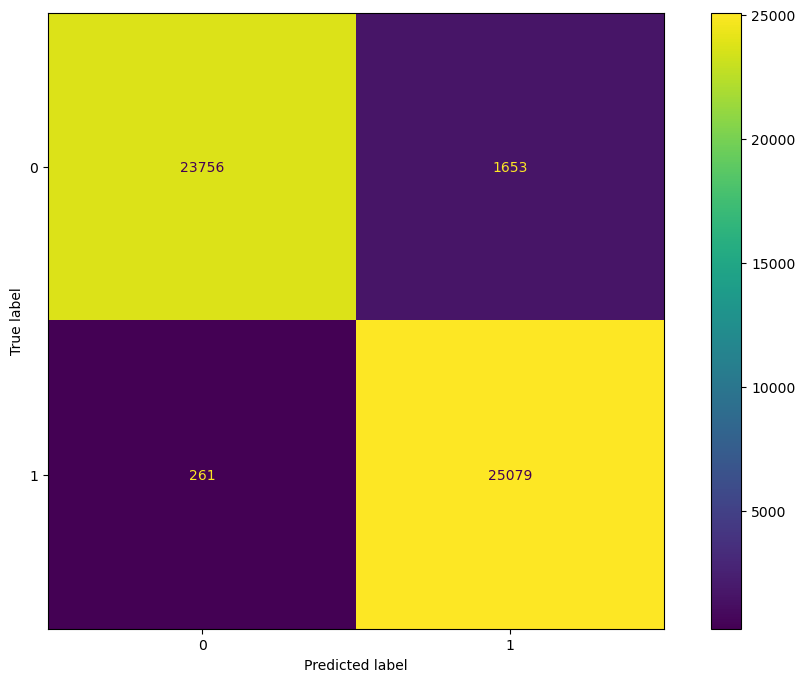

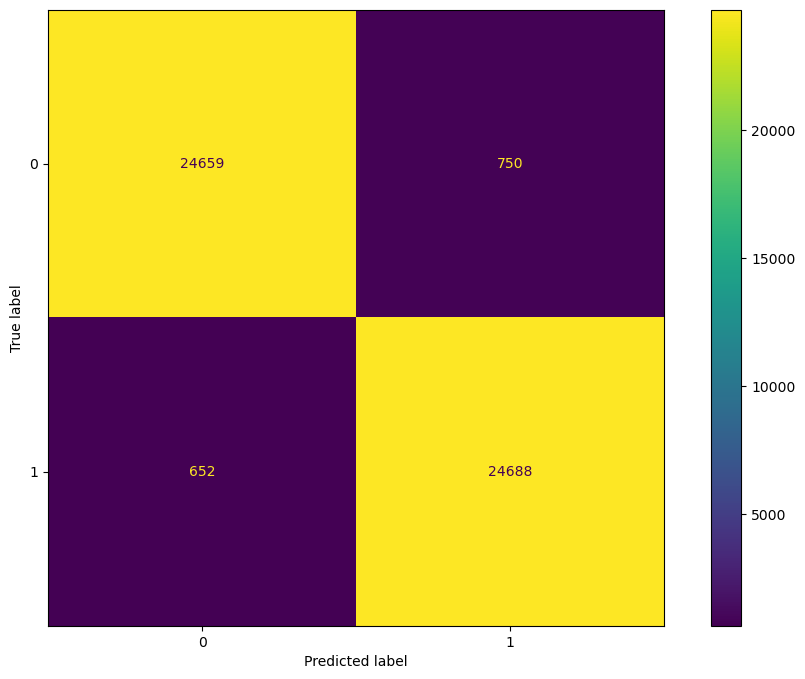

In [45]:
for clf in classifiers:
  clf.fit(x_train, y_train)
  name = clf.__class__.__name__
  print("="*30)
  print(name)
  print('****Resultados****')
  y_pred = clf.predict(x_test)
  print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
  print("Precision:", metrics.precision_score(y_test, y_pred))
  print("Recall:", metrics.recall_score(y_test, y_pred))
  print("F1:", metrics.f1_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()



Otimizando RandomForest

Parametros para testar

In [46]:
n_estimators = np.arange(20, 200, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


In [47]:
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}


In [49]:
SEED = 70

rforest = RandomForestClassifier(random_state=SEED)

In [50]:
random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter=5, cv=3, scoring="recall", n_jobs=-1, random_state = SEED
)


In [51]:
%%time
rcv = random_cv.fit(x, y)


c:\Users\Michael\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Michael\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Michael\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Michael\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Michael\anaconda3\Lib\site-p

CPU times: total: 54 s
Wall time: 2min 29s


In [52]:
rcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 9,
 'criterion': 'entropy',
 'bootstrap': True}

Resultados Finais

In [53]:
rfn = RandomForestClassifier(**rcv.best_params_, random_state = SEED)
model = rfn.fit(x_train, y_train)
y_pred = rfn.predict(x_test)


In [54]:
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))


Acurácia: 0.9915860411042582
Precisão: 0.9906258615936036
Recall: 0.9925414364640884
F1: 0.9915827238857459


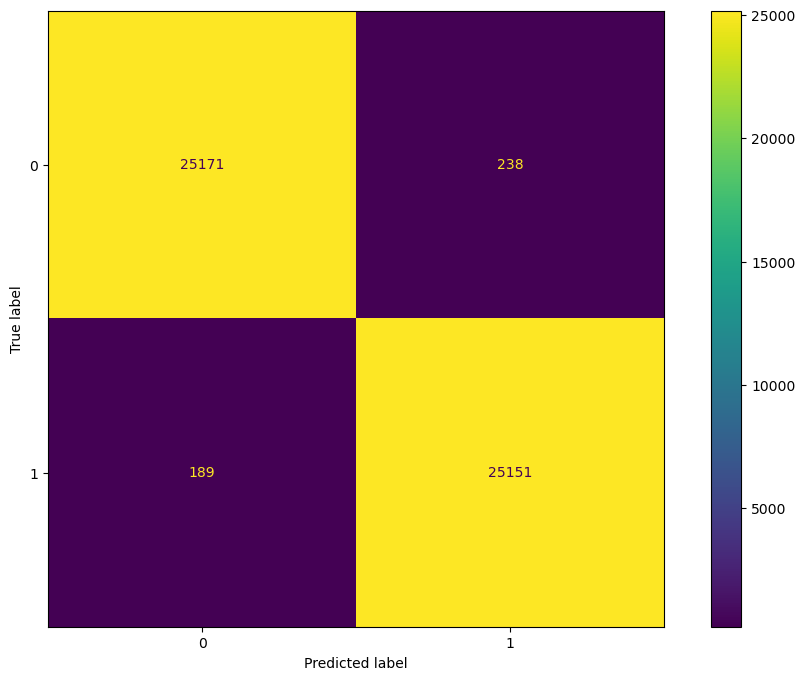

In [55]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Conclusão

*
- O cliente geralmente realiza transações financeiras durante o horário comercial, mas a fraude ocorreu em horários atípicos, como durante a madrugada.

- Além disso, observamos que o cliente tende a concentrar suas principais movimentações financeiras no início do mês, enquanto a fraude foi identificada em um dia não usual.

- O padrão de pagamento do cliente geralmente envolve o uso de dinheiro, seja por meio de PIX ou retiradas. No entanto, a fraude em questão envolveu um pagamento atípico por transferência.
*